Notebook 2: Baseline Modeling with SARIMA

Goal: To build a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model to forecast UPI transaction volumes.

Cell 1: Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Cell 2: Load and Prepare Data

We'll load the data from Notebook 1 and split it into a training set and a test set. We'll use the last 12 months of data for testing.

Training data points: 96
Test data points: 12


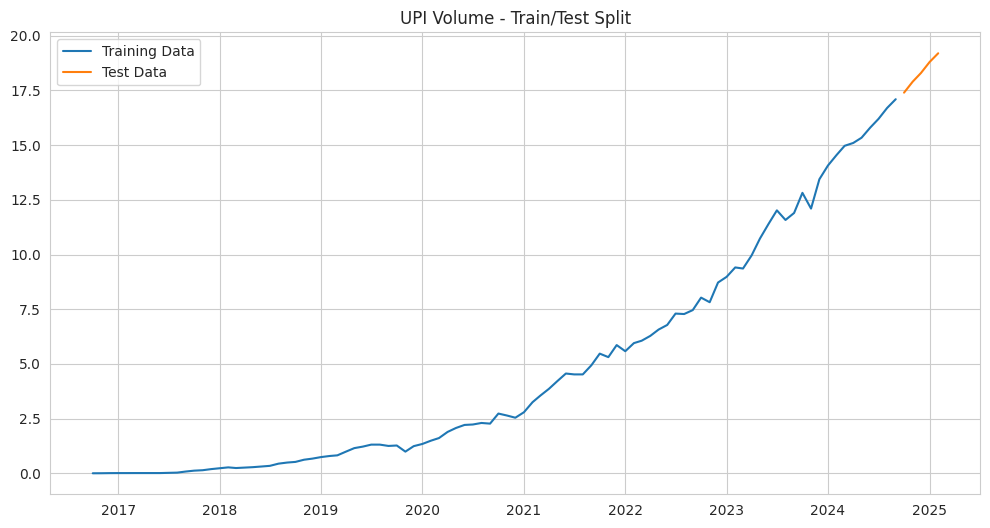

In [13]:
upi_df = pd.read_csv('upi_volumes.csv', index_col='Date', parse_dates=True)

# Split data into training and test sets
train_df = upi_df.iloc[:-12]
test_df = upi_df.iloc[-12:]

print(f"Training data points: {len(train_df)}")
print(f"Test data points: {len(test_df)}")

# Plot the split
plt.plot(train_df['Volume_Billion'], label='Training Data')
plt.plot(test_df['Volume_Billion'], label='Test Data')
plt.title('UPI Volume - Train/Test Split')
plt.legend()
plt.show()

Cell 3: Identify Model Parameters (p, d, q) and (P, D, Q)

To fit a SARIMA model, we need to determine its parameters. We'll use Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots for this. The strong trend and seasonality suggest we will need both regular and seasonal differencing.

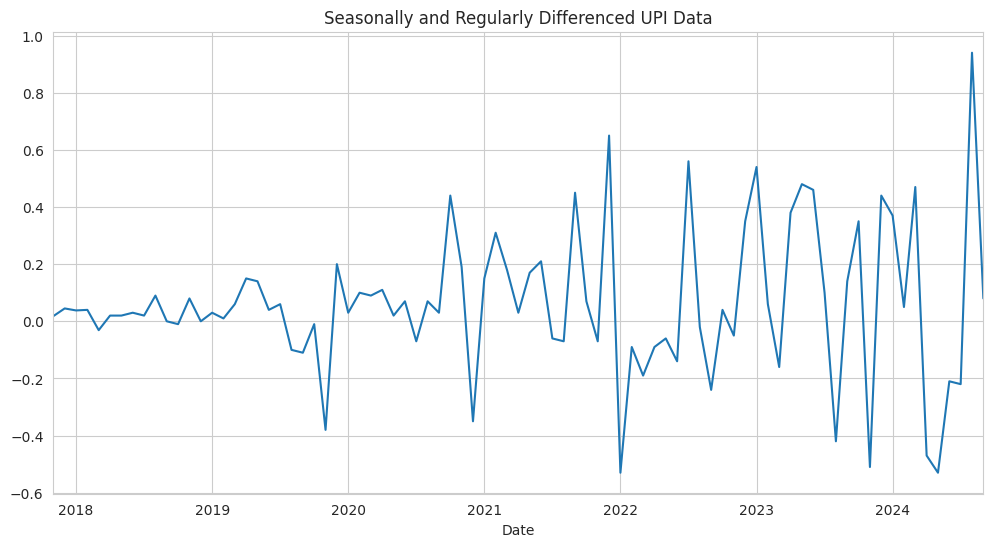

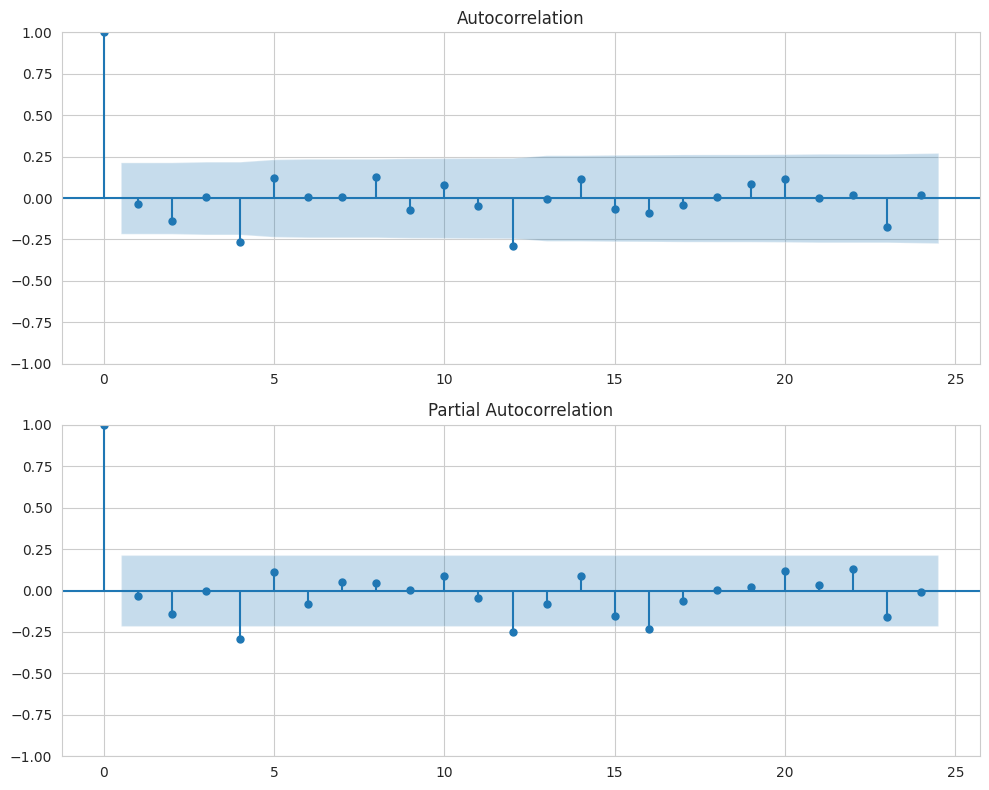

In [14]:
# Apply differencing to make the series stationary
# First, a seasonal difference (period=12 for yearly seasonality)
seasonal_diff = train_df['Volume_Billion'].diff(12).dropna()
# Then, a regular difference
regular_seasonal_diff = seasonal_diff.diff().dropna()

# Plot the differenced data to confirm stationarity
regular_seasonal_diff.plot(title='Seasonally and Regularly Differenced UPI Data')
plt.show()

# Now, plot ACF and PACF on the stationary data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(regular_seasonal_diff, ax=ax1, lags=24)
plot_pacf(regular_seasonal_diff, ax=ax2, lags=24)
plt.tight_layout()
plt.show()

Interpretation:

The ACF plot will likely show a significant spike at lag 1 and at the seasonal lag 12.

The PACF plot will also show spikes at lag 1 and lag 12. Based on this visual inspection, we'll start with a SARIMA model with parameters (p=1, d=1, q=1) for the non-seasonal part and (P=1, D=1, Q=1, m=12) for the seasonal part. This is a common and robust starting point for seasonal time series.

Cell 4: Fit the SARIMA Model

Now we'll instantiate and train the SARIMA model on our training data with the parameters we identified.

In [15]:
# Define the SARIMA model order
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12) # (P, D, Q, m)

# Create and fit the SARIMA model
sarima_model = SARIMAX(train_df['Volume_Billion'],
                       order=order,
                       seasonal_order=seasonal_order)

sarima_results = sarima_model.fit(disp=False)

# Print the model summary
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Volume_Billion   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -3.794
Date:                            Thu, 16 Oct 2025   AIC                             17.587
Time:                                    07:50:10   BIC                             29.682
Sample:                                10-01-2016   HQIC                            22.446
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6720      0.260     -2.588      0.010      -1.181      -0.163
ma.L1          0.8215      0.209   

Cell 5: Make and Evaluate Forecasts

Let's use our trained model to forecast the next 12 months and compare these predictions against our held-out test set.

SARIMA Model RMSE on Test Set (excluding NaNs): 0.3843


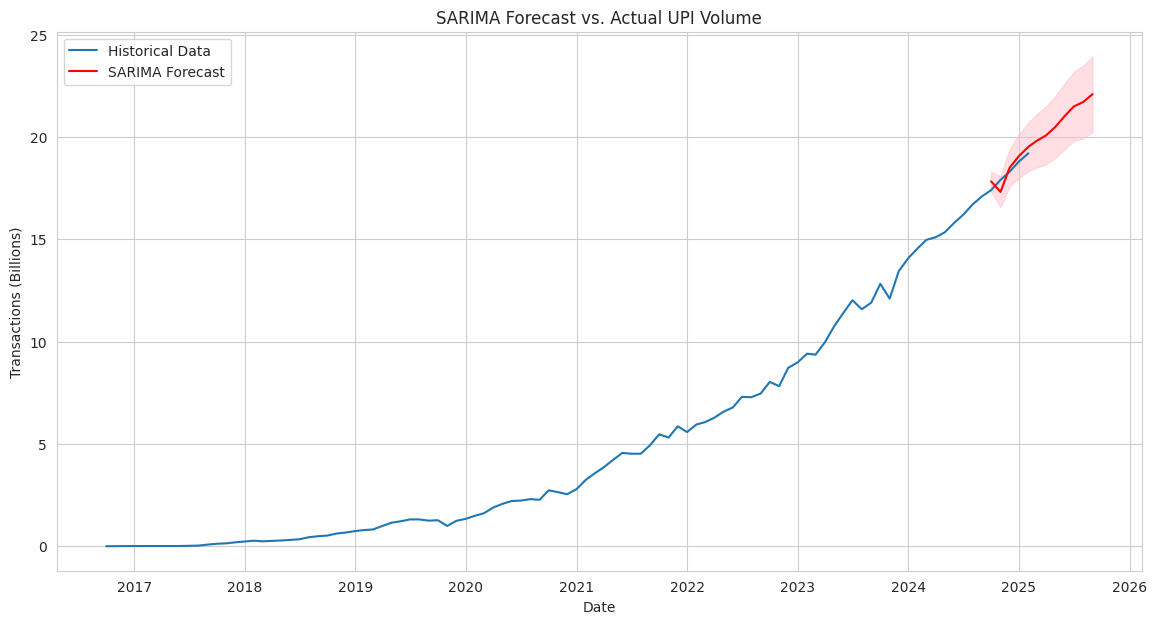

In [17]:
# Get forecast for the same period as the test set
forecast_steps = len(test_df)
forecast = sarima_results.get_forecast(steps=forecast_steps)

# Get the predicted values and confidence intervals
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Align the test data with the forecast by dropping NaNs from the test set
# This is necessary because the test_df was created with future dates that have NaN values
aligned_test_data = test_df['Volume_Billion'].dropna()
aligned_predicted_mean = predicted_mean[aligned_test_data.index]


# Calculate the Root Mean Squared Error (RMSE) on the non-missing values
rmse = np.sqrt(mean_squared_error(aligned_test_data, aligned_predicted_mean))
print(f'SARIMA Model RMSE on Test Set (excluding NaNs): {rmse:.4f}')

# Plot the forecast against the actual values
plt.figure(figsize=(14, 7))
plt.plot(upi_df.index, upi_df['Volume_Billion'], label='Historical Data')
plt.plot(predicted_mean.index, predicted_mean, color='red', label='SARIMA Forecast')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.5)
plt.title('SARIMA Forecast vs. Actual UPI Volume')
plt.xlabel('Date')
plt.ylabel('Transactions (Billions)')
plt.legend()
plt.show()

Cell 6: Analyze the Residuals

A good model should leave behind residuals (errors) that are random noise. If there's a pattern in the residuals, it means our model missed something, which is an opportunity for our LSTM in the next notebook.

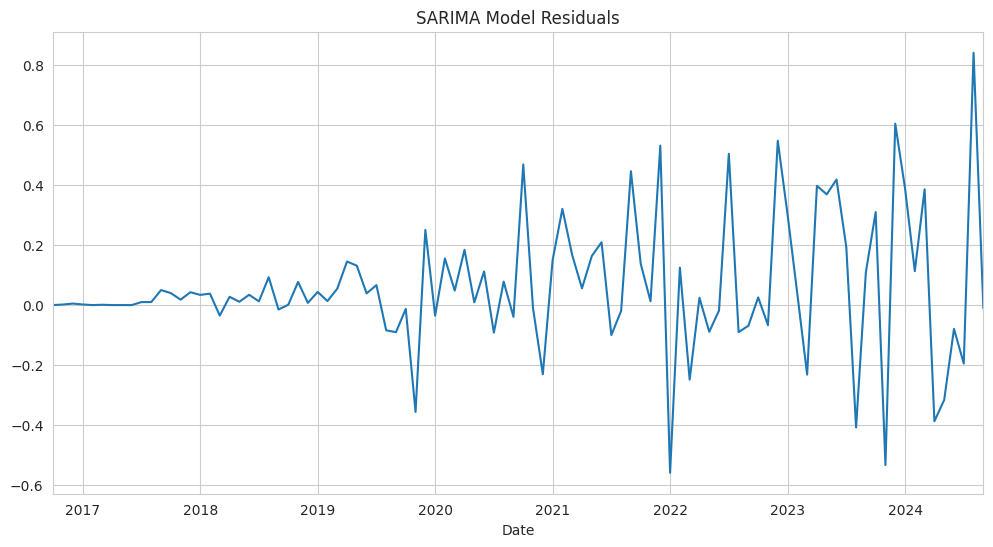

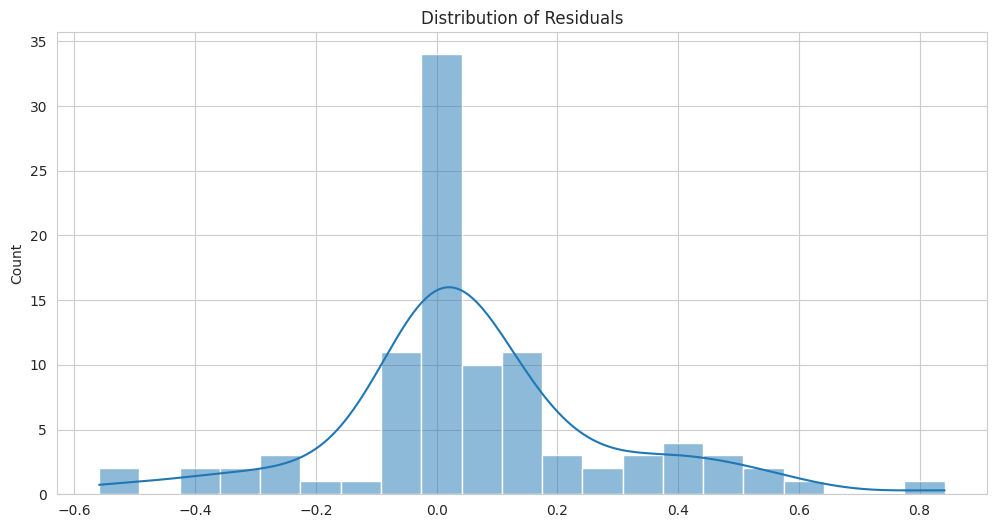

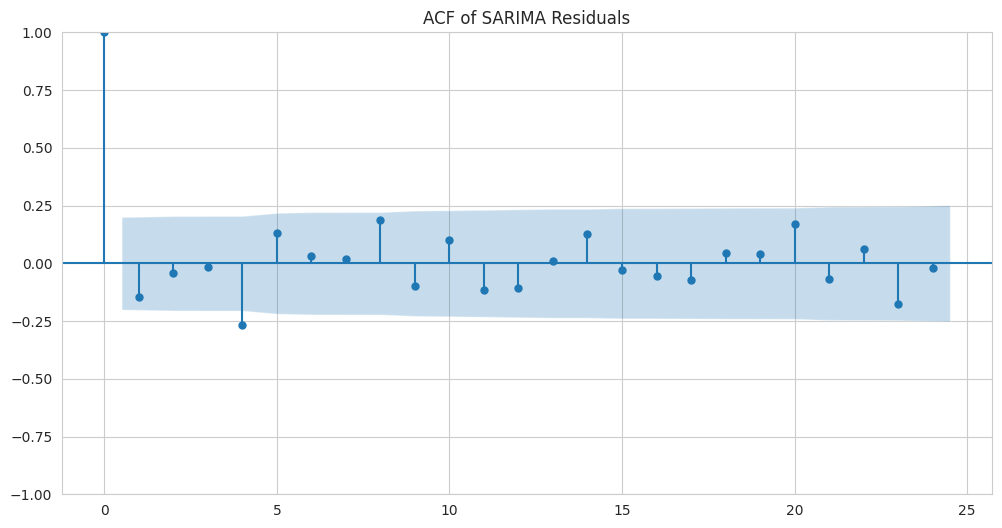

In [18]:
residuals = sarima_results.resid

# Plot the residuals
residuals.plot(title='SARIMA Model Residuals')
plt.show()

# Plot the distribution of residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

# Check for autocorrelation in residuals
plot_acf(residuals, lags=24)
plt.title('ACF of SARIMA Residuals')
plt.show()

Observation: While the residuals might look mostly random, there will likely be some small but significant spikes in the ACF plot. These small, uncaptured non-linear patterns are exactly what we will try to model with our LSTM.

Cell 7: Save the Residuals for Notebook 3

Finally, we save the residuals of the SARIMA model. This will be the training data for our LSTM.

In [19]:
residuals_df = pd.DataFrame({'Residuals': residuals})
residuals_df.to_csv('sarima_residuals.csv')

print("SARIMA model residuals saved to sarima_residuals.csv")

SARIMA model residuals saved to sarima_residuals.csv
